# Análise exploratória

In [4]:
import csv
import sys
import pandas
import sqlalchemy
import sqlalchemy.orm as orm
import os
import json
import re
import html
import unicodedata
import ast
from dotenv import load_dotenv
from datetime import datetime

## Conectar com o banco de dados

O procedimento para conectar com o banco de dados segue o mesmo apresentado no arquivo `02-preprocessamento.ipynb`.

### Variáveis de ambiente e motor de conexão

In [5]:
# Carregar variáveis de ambiente
load_dotenv()
POSTGRES_HOST = os.getenv("POSTGRES_HOST")
POSTGRES_PORT = os.getenv("POSTGRES_PORT")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_DB = os.getenv("POSTGRES_DB")

# Verificar se todas as variáveis foram carregadas
required_vars = {
    "POSTGRES_HOST": POSTGRES_HOST,
    "POSTGRES_PORT": POSTGRES_PORT,
    "POSTGRES_USER": POSTGRES_USER,
    "POSTGRES_PASSWORD": POSTGRES_PASSWORD,
    "POSTGRES_DB": POSTGRES_DB,
}

missing = [k for k, v in required_vars.items() if not v]
if missing:
    raise EnvironmentError(f"Variáveis de ambiente ausentes: {', '.join(missing)}")

# URL de conexão com o banco de dados
DATABASE_URL = (
    f"postgresql+psycopg://{POSTGRES_USER}:{POSTGRES_PASSWORD}"
    f"@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)

# Criar o motor de conexão com o banco de dados
engine = sqlalchemy.create_engine(DATABASE_URL)

# Testar a conexão com o banco de dados
try:
    with engine.connect() as connection:
        print("✅ Conexão com o banco de dados estabelecida com sucesso!")
except Exception as e:
    print(f"❌ Erro ao conectar ao banco de dados: {e}")

✅ Conexão com o banco de dados estabelecida com sucesso!


### Tabelas de associação

In [6]:
Base = orm.declarative_base()

game_developer = sqlalchemy.Table(
    "game_developer",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("developer_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("developers.id"), primary_key=True)
)

game_publisher = sqlalchemy.Table(
    "game_publisher",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("publisher_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("publishers.id"), primary_key=True)
)

game_category = sqlalchemy.Table(
    "game_category",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("category_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("categories.id"), primary_key=True)
)

game_genre = sqlalchemy.Table(
    "game_genre",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("genre_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("genres.id"), primary_key=True)
)

game_tag = sqlalchemy.Table(
    "game_tag",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("tag_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("tags.id"), primary_key=True)
)

game_language = sqlalchemy.Table(
    "game_language",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("language_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("languages.id"), primary_key=True)
)

### Definição dos modelos

In [7]:
class Developer(Base):
    __tablename__ = "developers"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)

    games = orm.relationship("Game", secondary=game_developer, back_populates="developers")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Publisher(Base):
    __tablename__ = "publishers"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)

    games = orm.relationship("Game", secondary=game_publisher, back_populates="publishers")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Category(Base):
    __tablename__ = "categories"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_category, back_populates="categories")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Genre(Base):
    __tablename__ = "genres"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_genre, back_populates="genres")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Tag(Base):
    __tablename__ = "tags"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_tag, back_populates="tags")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Language(Base):
    __tablename__ = "languages"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_language, back_populates="languages")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Screenshot(Base):
    __tablename__ = "screenshots"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    game_id = sqlalchemy.Column(sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), nullable=False)
    screenshot_url = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)


class Movie(Base):
    __tablename__ = "movies"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    game_id = sqlalchemy.Column(sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), nullable=False)
    movie_url = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)


class Game(Base):
    __tablename__ = "games"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    app_id = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)
    release_date = sqlalchemy.Column(sqlalchemy.Date, nullable=False)
    estimated_owners_lower = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    estimated_owners_upper = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    peak_ccu = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    required_age = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    price = sqlalchemy.Column(sqlalchemy.Float, nullable=False, default=0.0)
    discount = sqlalchemy.Column(sqlalchemy.Float, nullable=False, default=0.0)
    dlc_count = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    about_the_game = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    header_image = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    website = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    support_url = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    support_email = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    windows = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    mac = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    linux = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    metacritic_score = sqlalchemy.Column(sqlalchemy.Float, nullable=True)
    metacritic_url = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    user_score = sqlalchemy.Column(sqlalchemy.Float, nullable=True)
    positive = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    negative = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    score_rank = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    achievements = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    recommendations = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    average_playtime_forever = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    average_playtime_2weeks = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    median_playtime_forever = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    median_playtime_2weeks = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)

    # RELACIONAMENTOS M:N
    developers = orm.relationship("Developer", secondary=game_developer, back_populates="games")
    publishers = orm.relationship("Publisher", secondary=game_publisher, back_populates="games")
    categories = orm.relationship("Category", secondary=game_category, back_populates="games")
    genres = orm.relationship("Genre", secondary=game_genre, back_populates="games")
    tags = orm.relationship("Tag", secondary=game_tag, back_populates="games")
    languages = orm.relationship("Language", secondary=game_language, back_populates="games")


### Sessão para comunicação com banco

In [8]:
session = sqlalchemy.orm.Session(engine)

### Funções utilitárias

In [19]:
def format_number(number):
    """
    Formata um número para ser exibido com separadores de milhares
    Ex: 1000000 -> 1.000.000
    Ex: 1000000000 -> 1.000.000.000
    Ex: 123456.789 -> 123.456,789
    """
    # Converte para string para tratar parte inteira e decimal
    number_str = str(number)

    if "." in number_str:
        integer_part, decimal_part = number_str.split(".")
    else:
        integer_part = number_str
        decimal_part = None

    # Formata a parte inteira com separadores de milhar
    integer_part = "{:,}".format(int(integer_part)).replace(",", ".")

    # Junta novamente com a parte decimal, se existir
    if decimal_part is not None:
        return f"{integer_part},{decimal_part}"

    return integer_part

## Análise de Jogos

### Grátis vs Pagos

A grande maioria dos jogos na Steam são pagos, mas há uma quantidade significativa de jogos gratuitos.

Jogos gratuitos: 23247
Jogos pagos: 88205
Total de jogos: 111452


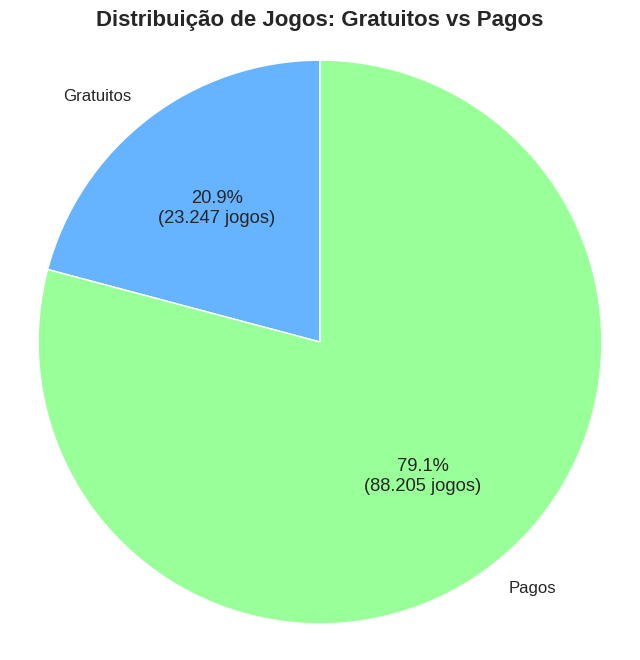

In [22]:
from sqlalchemy import func, case
import matplotlib.pyplot as plt

# Query
result = session.query(
    func.sum(case((Game.price == 0, 1), else_=0)).label("free_games"),
    func.sum(case((Game.price > 0, 1), else_=0)).label("paid_games"),
).first()

free_games, paid_games = result
total_games = free_games + paid_games

print(f"Jogos gratuitos: {free_games}")
print(f"Jogos pagos: {paid_games}")
print(f"Total de jogos: {total_games}")

# Função para mostrar porcentagem + quantidade
def autopct_format(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({format_number(count)} jogos)"

    return my_autopct


# Criar gráfico de pizza
labels = ["Gratuitos", "Pagos"]
sizes = [free_games, paid_games]
colors = ["#66b3ff", "#99ff99"]

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=autopct_format(sizes),
    startangle=90,
)
plt.title(
    "Distribuição de Jogos: Gratuitos vs Pagos",
    fontsize=16,
    fontweight="bold",
)
plt.axis("equal")
plt.show()